In [1]:
#Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler


In [2]:
# Import data from CSV file
data = pd.read_excel('churn.xlsx')

In [3]:
# Function to clean column names

def column_name_remove_space(df):
    for x in df.columns:
        if " " in x:
            df = df.rename(columns={x:x.replace(" ","_").replace("(","")
                                    .replace(")","").replace(",","_").replace("/","_")})
    return df

In [4]:
# Check for null values
data.isna().any(axis=0).any()

False

Modelo Inicial

In [5]:
# Following columns have categorical data types and they need to be converted to dummy variables
dummy_variable_columns = to_plot = ['GENDER','BILLING_PLATFORM','HAS_FREE_TRIAL','SUBSCRIPTION_PERIOD','BY_CAMPAIGN',
                                    'SUBSCRIPTION_TYPE','HAS_ANY_KIDS_PROFILE_STREAMING','PRODUCT_SWITCH','IS_RECONNECT_PAID_TO_PAID','IS_RECONNECT_PAID_TO_TRIAL',
                                    'IS_RECONNECT_TRIAL_TO_PAID','IS_RECONNECT_TRIAL_TO_TRIAL','STREAM_SPORTS','STREAM_SERIES',
                                    'STREAM_MOVIES','PAYMENT_METHOD','PURCHASE_DEVICE_TYPE', 'CHURN']


# Following columns have continuous numerical data, which needs to be scaled before predictive model can be created.
# Hence, these columns will be transformed to normalized form.

to_transform = ['DISTINCT_TITLES','DAYS_SINCE_LAST_STREAM','MINS_WATCHED', 'DEVICE_COUNT',
                'DAYS_STREAM','NUMB_OF_PROFILES','CHILDREN','AGE_IN_MONTHS']

dummy_data_file_index = 0

In [6]:

def get_dummy_data_with_output(dummy_variable_columns, data):
    global dummy_data_file_index
    dummy_data = pd.get_dummies(data, prefix=dummy_variable_columns, columns=dummy_variable_columns, drop_first= True)
    dummy_data = column_name_remove_space(dummy_data)
    dummy_data.to_csv('dummy_var_data'+str(dummy_data_file_index)+'.csv', index=False)
    y = dummy_data['CHURN_Yes']
    dummy_data.drop(columns=['CHURN_Yes'], inplace=True)
    sc = StandardScaler()
    dummy_data.loc[:,to_transform] = sc.fit_transform(dummy_data.loc[:,to_transform])
    dummy_data_file_index += 1
    return y, dummy_data

y, dummy_data = get_dummy_data_with_output(dummy_variable_columns, data)

In [7]:
# Split the training and test set 7:3 
X_train, X_test, y_train, y_test = train_test_split(dummy_data,y,test_size=.3, random_state=0)

In [8]:
# Creating a function to create prediction model based on statsmodel library and
# print details like model Summary, Confusion Matrix and Accuracy Score based on predicted values using test set

def get_sm_model(y_train,X_train, X_test):
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    logit_model=sm.Logit(y_train,X_train)
    model=logit_model.fit()
    print(model.summary())
    y_hat = list(map(round, model.predict(X_test)))
    arr = np.c_[y_hat, y_test]
    print('\nPrinting predicted and actual values:\n',arr)
    print('Confusion Matrix \n',confusion_matrix(y_test, y_hat))
    print('Accuracy Score: ',accuracy_score(y_test, y_hat))
    return model, arr

# Creating a function to create prediction model based on sklearn library and
# print details like model Summary, Confusion Matrix and Accuracy Score based on predicted values using test set

def get_sk_model(y_train,X_train, X_test):
    model = LogisticRegression(max_iter=100000000)
    model.fit(X_train, y_train)
    arr = np.c_[X_train.columns.tolist(),model.coef_[0]]
    intercept = model.intercept_[0]
    print('\nPrinting model coefficients and intercept summary for sklearn model:\n',arr, model.intercept_)
    y_pred = model.predict(X_test)
    print('\nPrinting predicted and actual values from sklearn:\n',np.c_[y_pred, y_test])
    print('Confusion Matrix from sklearn\n',confusion_matrix(y_test, y_pred))
    plt.matshow(confusion_matrix(y_test, y_pred))
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(b=None)
    plt.show()
    print('Accuracy Scores from sklearn:\n',accuracy_score(y_test, y_pred))
    print('Classification Report from sklearn:\n',classification_report(y_test, y_pred))
    return model, arr, intercept


# Function to create AUC chart and print AUC score.
# AUC score closer to 1 is considered a good model
# Auc score of 0.5 represents are model which is no
# better than a random guess with 50% chance of predicting the right outcome

from sklearn.metrics import roc_curve
def roc(model, X_test, y_test):
    probs = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, probs[:,1])
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    print('AUC: %.3f' % roc_auc_score(y_test, probs[:,1]))

c:\Users\ciafa001\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\ciafa001\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
c:\Users\ciafa001\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\Users\ciafa001\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: inf
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              CHURN_Yes   No. Observations:                 7000
Model:                          Logit   Df Residuals:                     6967
Method:                           MLE   Df Model:                           32
Date:                Mon, 12 Sep 2022   Pseudo R-squ.:                     inf
Time:                        12:22:01   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -2.9525      0.973   

C:\Users\ciafa001\AppData\Local\Temp\15\ipykernel_8532\2153310723.py:34: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


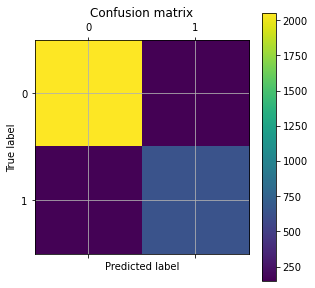

Accuracy Scores from sklearn:
 0.8966666666666666
Classification Report from sklearn:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      2201
           1       0.81      0.80      0.80       799

    accuracy                           0.90      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.90      0.90      0.90      3000



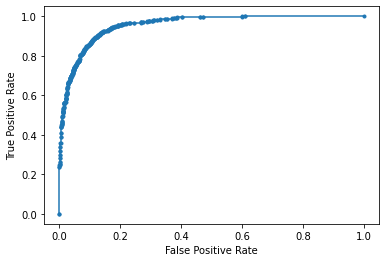

AUC: 0.956


In [9]:
# Run statsmodel function
get_sm_model(y_train,X_train, X_test);
# Run sklearn model
model, arr, intercept = get_sk_model(y_train,X_train, X_test);
# Run AUC
roc(model, X_test, y_test);

Modelo Final

In [19]:
data_reduced = data[['NUMB_OF_PROFILES','DAYS_SINCE_LAST_STREAM', 'DISTINCT_TITLES', 'CHURN','BILLING_PLATFORM', 'HAS_FREE_TRIAL','SUBSCRIPTION_PERIOD', 
                     'BY_CAMPAIGN','SUBSCRIPTION_TYPE','HAS_ANY_KIDS_PROFILE_STREAMING',
                     'STREAM_SERIES','STREAM_MOVIES','PAYMENT_METHOD', 'STREAM_SPORTS', 'PRODUCT_SWITCH', 'IS_RECONNECT_PAID_TO_PAID', 'IS_RECONNECT_TRIAL_TO_TRIAL']]

dummy_variable_columns = ['CHURN','BILLING_PLATFORM', 'HAS_FREE_TRIAL','SUBSCRIPTION_PERIOD', 'BY_CAMPAIGN','SUBSCRIPTION_TYPE','HAS_ANY_KIDS_PROFILE_STREAMING',
                          'STREAM_SERIES','STREAM_MOVIES','PAYMENT_METHOD', 'STREAM_SPORTS', 'PRODUCT_SWITCH', 'IS_RECONNECT_PAID_TO_PAID', 'IS_RECONNECT_TRIAL_TO_TRIAL']

to_transform = ['NUMB_OF_PROFILES','DAYS_SINCE_LAST_STREAM', 'DISTINCT_TITLES']

data_diff = [i for i in data.columns.tolist() + data_reduced.columns.tolist() if i not in data.columns.tolist() or i not in data_reduced.columns.tolist()]


In [20]:

y, dummy_data_reduced = get_dummy_data_with_output(dummy_variable_columns, data_reduced)

In [21]:
# Split the training and test set 7:3 
X_train, X_test, y_train, y_test = train_test_split(dummy_data_reduced,y,test_size=.3, random_state=0)


c:\Users\ciafa001\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\ciafa001\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
c:\Users\ciafa001\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\Users\ciafa001\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: inf
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              CHURN_Yes   No. Observations:                 7000
Model:                          Logit   Df Residuals:                     6977
Method:                           MLE   Df Model:                           22
Date:                Mon, 12 Sep 2022   Pseudo R-squ.:                     inf
Time:                        12:41:04   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -3.1625      0.361   

C:\Users\ciafa001\AppData\Local\Temp\15\ipykernel_8532\2153310723.py:34: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


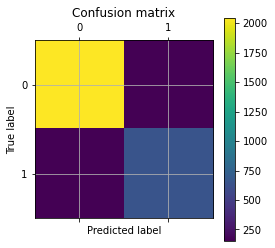

Accuracy Scores from sklearn:
 0.8966666666666666
Classification Report from sklearn:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      2201
           1       0.81      0.80      0.81       799

    accuracy                           0.90      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.90      0.90      0.90      3000



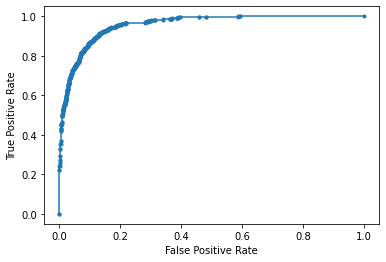

AUC: 0.957


In [22]:
# Run statsmodel on reduced data set
get_sm_model(y_train,X_train, X_test);
# Run sklearn model on reduced data set
model, arr, intercept = get_sk_model(y_train,X_train, X_test);
roc(model, X_test, y_test);

Análisis Adicionales

AxesSubplot(0.125,0.125;0.775x0.755)


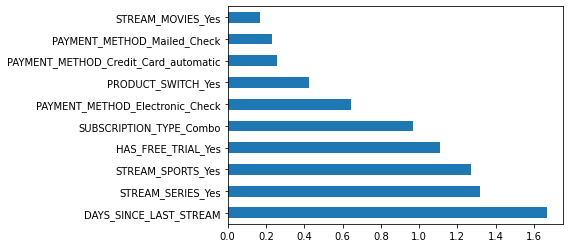

In [23]:
# To get the weights of all the variables
weights = pd.Series(model.coef_[0],
                 index=dummy_data_reduced.columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='barh'))

In [34]:
# Function to calculate the reduction percentage in odds ratio
def impact(coeff, field,x, categorical=False):
    if categorical:
        exp = np.exp(x*coeff)
        print ( field, ': Odds Ratio Reduction : '+str(round((1 - exp)*100,2 ))+'%')
    else:
        exp1 = np.exp(x*coeff/data_reduced['DAYS_SINCE_LAST_STREAM'].std())
        exp2 = np.exp(-1*x*coeff/data_reduced['DAYS_SINCE_LAST_STREAM'].std())
        print ( field, ': Odds Ratio Reduction with unit increase: '+str(round((1 - exp1)*100,2 ))+'%', 'Odds Ratio Reduction with unit decrease: '+str(round((1 - exp2)*100,2 ))+'%')

        

impact(1.67,'DAYS_SINCE_LAST_STREAM',1)
impact(1.67,'DAYS_SINCE_LAST_STREAM',15)
impact(1.67,'DAYS_SINCE_LAST_STREAM',10)

DAYS_SINCE_LAST_STREAM : Odds Ratio Reduction with unit increase: -46.87% Odds Ratio Reduction with unit decrease: 31.91%
DAYS_SINCE_LAST_STREAM : Odds Ratio Reduction with unit increase: -31800.31% Odds Ratio Reduction with unit decrease: 99.69%
DAYS_SINCE_LAST_STREAM : Odds Ratio Reduction with unit increase: -4568.71% Odds Ratio Reduction with unit decrease: 97.86%


In [25]:
# Code to print the equation

equation = ''

for a in arr:
    if not a[0].startswith('State'):
        new = str(round(float(a[1].replace("\'","")),2))+' x '+a[0].replace("\'","").replace('_Yes','')
        if new.startswith('-'):
            equation = equation + ' ' + new + ' '
        else:
            equation = equation + ' +' + new + ' '
interceptstr = str(round(intercept,2))

if interceptstr.startswith('-'):
    equation = equation + ' ' + interceptstr
else:
    equation = equation + ' +' + interceptstr

y = 'exp(-1x('+equation+'))'

print ('P (Y=1|X) = 1 / (1 + '+y+')')

P (Y=1|X) = 1 / (1 + exp(-1x( +0.08 x NUMB_OF_PROFILES  +1.67 x DAYS_SINCE_LAST_STREAM  -3.07 x DISTINCT_TITLES  -0.03 x BILLING_PLATFORM_APPLE  -0.01 x BILLING_PLATFORM_DIRECT  -0.17 x BILLING_PLATFORM_GOOGLE  +1.11 x HAS_FREE_TRIAL  -3.34 x SUBSCRIPTION_PERIOD_One_year  -3.41 x SUBSCRIPTION_PERIOD_Two_Year  +0.15 x BY_CAMPAIGN  +0.97 x SUBSCRIPTION_TYPE_Combo  -1.05 x SUBSCRIPTION_TYPE_Standalone  -0.4 x HAS_ANY_KIDS_PROFILE_STREAMING  +1.32 x STREAM_SERIES  +0.17 x STREAM_MOVIES  +0.26 x PAYMENT_METHOD_Credit_Card_automatic  +0.64 x PAYMENT_METHOD_Electronic_Check  +0.23 x PAYMENT_METHOD_Mailed_Check  +1.27 x STREAM_SPORTS  +0.42 x PRODUCT_SWITCH  -0.25 x IS_RECONNECT_PAID_TO_PAID  -0.22 x IS_RECONNECT_TRIAL_TO_TRIAL  -3.05)))
